### Анализ данных в задаче кредитного скоринга

In [1]:
import os
import tqdm
import scipy
import scipy.stats as st
import statsmodels as stm
import numpy as np
import pandas as pd
import seaborn as sns
import multiprocessing as mp
import matplotlib.pyplot as plt

from scipy import stats

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set()

In [2]:
# Версии использованных пакетов.
%load_ext watermark
%watermark -v -p scipy,statsmodels,numpy,pandas,matplotlib,seaborn

CPython 3.7.6
IPython 7.13.0

scipy 1.4.1
statsmodels 0.11.1
numpy 1.18.2
pandas 1.0.3
matplotlib 3.2.1
seaborn 0.10.0


__Описание данных__

* LIMIT_BAL: размер кредитного лимита (в том числе и на семью клиента)
* SEX: пол клиента (1 = мужской, 2 = женский )
* EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных ).
* MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных).
* AGE: возраст в годах
* PAY_0 - PAY_6 : История прошлых платежей по кредиту. PAY_6 - платеж в апреле, ... Pay_0 - платеж в сентябре. Платеж = (0 = исправный платеж, 1=задержка в один месяц, 2=задержка в 2 месяца ...)
* BILL_AMT1 - BILL_AMT6: задолженность, BILL_AMT6 - на апрель, BILL_AMT1 - на сентябрь
* PAY_AMT1 - PAY_AMT6: сумма уплаченная в PAY_AMT6 - апреле, ..., PAY_AMT1 - сентябре
* default - индикатор невозврата денежных средств

__Описание задания__

1. Размер кредитного лимита (LIMIT_BAL). В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы: a) о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?
    
    
2. Пол (SEX): Проверьте гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается. Хорошо, если вы предоставите несколько различных решений этой задачи (с помощью доверительного интервала и подходящего статистического критерия)
    
    
3. Образование (EDUCATION): Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг. Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек. Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости ? Наличие какого образования является наилучшим индикатором того, что человек отдаст долг ? наоборт, не отдаст долг ?


4. Семейное положение (MARRIAGE): Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.


5. Возраст (AGE): Относительно двух групп людей вернувших и не вернувших кредит проверьте следующие гипотезы: a) о равенстве медианных значений возрастов людей b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?


__Важно:__

* Каждая задача начинается с визуальной аналитики данных с разбивкой по параметру default.
* Обусловлена применимость статистического критерия.
* При каждом использовании любого критерия необходимо указать, какая проверяется гипотеза, против какой альтернативы, чему равен достигаемый уровень значимости, принимается или отвергается нулевая гипотеза на уровне значимости 0.05. Если задача позволяет, нужно оценить размер эффекта и предположить, имеет ли этот результат практическую значимость. 

---

Чтение данных

In [3]:
df = pd.read_csv('credit_card_default_analysis.csv')
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   ID         30000 non-null  int64
 1   LIMIT_BAL  30000 non-null  int64
 2   SEX        30000 non-null  int64
 3   EDUCATION  30000 non-null  int64
 4   MARRIAGE   30000 non-null  int64
 5   AGE        30000 non-null  int64
 6   PAY_0      30000 non-null  int64
 7   PAY_2      30000 non-null  int64
 8   PAY_3      30000 non-null  int64
 9   PAY_4      30000 non-null  int64
 10  PAY_5      30000 non-null  int64
 11  PAY_6      30000 non-null  int64
 12  BILL_AMT1  30000 non-null  int64
 13  BILL_AMT2  30000 non-null  int64
 14  BILL_AMT3  30000 non-null  int64
 15  BILL_AMT4  30000 non-null  int64
 16  BILL_AMT5  30000 non-null  int64
 17  BILL_AMT6  30000 non-null  int64
 18  PAY_AMT1   30000 non-null  int64
 19  PAY_AMT2   30000 non-null  int64
 20  PAY_AMT3   30000 non-null  int64
 21  PAY_AMT4   3

In [5]:
df.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,0.356767,0.320033,0.304067,0.258767,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,0.760594,0.801727,0.790589,0.761113,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,0.000000,0.000000,0.000000,0.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [6]:
df['default'].value_counts()

0    23364
1     6636
Name: default, dtype: int64

Зададим уровень значимость alpha по-умолчанию.

In [7]:
alpha = 0.05

__Задача 1.__
Размер кредитного лимита (`LIMIT_BAL`). В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы: 
 * a) о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки;
 * b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних.
 
Значимы ли полученные результаты с практической точки зрения ?

In [8]:
def plot_grouped_feature(df, col_name, group, label_name, figsize=(12,5)):
    """
    Нарисовать kernel density estimation (KDE) графики распределения признака по бинарному показателю,
    а также ящики с усами.
    
    Arguments:
            df: pandas DataFrame
            col_name: название бинарного признака
            group: группа агрегации признака
            label_name:  подпись
            figsize: размер графика
    
    Returns: None
    """
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    _alpha = 0.6

    plt.suptitle(f'Распределение признака: {col_name}')
    sns.kdeplot(df.loc[df[group] == 0, col_name], color= 'green', label=f'{label_name}: 0',
                ax=axes[0], alpha=_alpha)
    sns.kdeplot(df.loc[df[group] == 1, col_name], color= 'blue', label=f'{label_name}: 1', 
                ax=axes[0], alpha=_alpha)
    
    sns.boxplot(x=df[group], y=df[col_name], palette =['green', 'blue'],
                ax=axes[1],  boxprops=dict(alpha=_alpha))
    plt.xlabel(f'{label_name} ({group})')

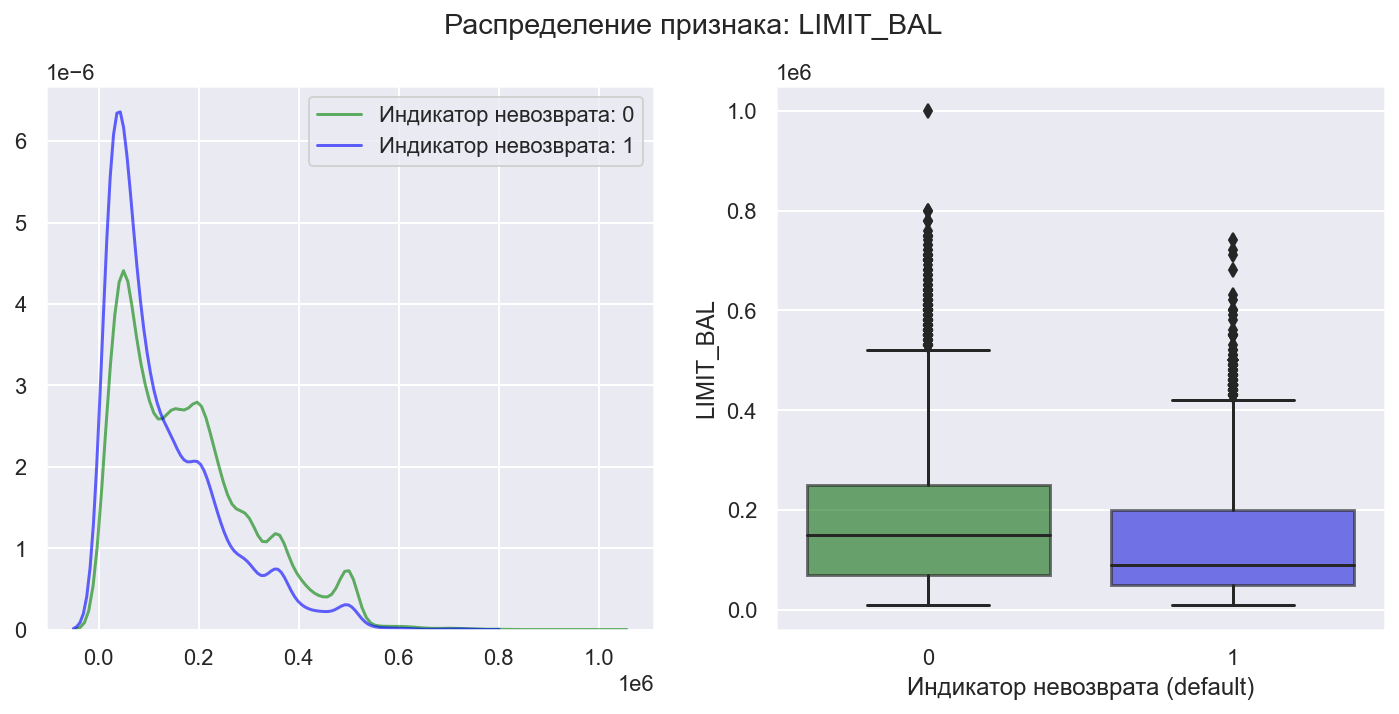

In [9]:
plot_grouped_feature(df, 'LIMIT_BAL', 'default', 'Индикатор невозврата')

Из графиков можно видеть, что медиана кредитного лимита `LIMIT_BAL` для группы клиентов, имеющих невовзрат денежных средств, ниже, чем у группы без возврата. В целом эта закономерность видится адекватной. У людей с меньшим доходом и большим риском проблем с возвратами кредитов меньше возможностей получить дополнительную кредитную денежную подушку. 

__a)__
Проведем интервальную оценку медианы с помощью бутстрепа. Для этого сгенерируем из выборки данных по группам default=1 и default=0 псевдовыборки с возвращением. Для каждой пары псевдовыборок расчитаем разницу их медиан и рассмотрим распределение разности медиан для сгенерированных псевдовыборок.

In [10]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [11]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [12]:
# Для а) бутстреп и разница медиан
# Для б) критерий Мана-Уитни

In [13]:
limit_ball_default_1 = df[df['default']==1]['LIMIT_BAL'].values
limit_ball_default_0 = df[df['default']==0]['LIMIT_BAL'].values

In [14]:
np.random.seed(0)

lb_def_1_median_scores = np.array(list(map(np.median, get_bootstrap_samples(limit_ball_default_1, 1000))))
lb_def_0_median_scores = np.array(list(map(np.median, get_bootstrap_samples(limit_ball_default_0, 1000))))

In [15]:
diff_value = lb_def_0_median_scores - lb_def_1_median_scores
stat_intervals(diff_value, alpha)

array([60000., 70000.])

Интервальная оценка разницы медиан с помощью бутстрепа показывает, что группа клиентов, не имеющих задолженнойстей по выплате кредитов, в среднем имеют больший объем кредитных средств.

__b)__ Поскольку распределение признака `LIMIT_BAL` не является нормальным, нет возможности воспользоваться стандартными параметрическими тестами. Сравниваются значения по двум независимым выборкам, поэтому для проверки гипотезы о равенстве распределений с помощью рангового критерия равенства средних воспользуемся непараметрическим тестом Уилкоксона-Мана-Уитни. 

H0: $F_{LimitBal|default=1}(x) = F_{LimitBal|default=0}(x)$

H1: $F_{LimitBal|default=1}(x) = F_{LimitBal|default=0}(x+\Delta)$

$alpha = 0.05$

In [16]:
stats.mannwhitneyu(limit_ball_default_1, limit_ball_default_0, alternative ='two-sided')

MannwhitneyuResult(statistic=59257217.5, pvalue=1.2255485818223303e-189)

p-value, т.е. достигаемый уровень значимости для проведенного теста ~0. 

__Соответственно, гипотеза H0: $F_{LimitBal|default=1}(x) = F_{LimitBal|default=0}(x)$ отвергается при заданном уровне alpha=0.05.__

Нельзя отвергать тот факт, что распределение лимита баланса кредитов у лиц, имеющих задолженность, отличается от распределения лимита баланса лиц без задолженностей. В целом лимит кредитного баланса у лиц без задолженностей больше, что является логичным.

С точки зрения управления кредитными ресурсами вывод не является практически значимым.

С точки зрения оценки грамотности внутреннего управления средствами кредитного баланса вывод является практически значимым.

---

__Задача 2.__

Пол (SEX): Проверьте гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается. Хорошо, если вы предоставите несколько различных решений этой задачи (с помощью доверительного интервала и подходящего статистического критерия).

In [17]:
df['SEX'].unique()

array([2, 1], dtype=int64)

In [18]:
# Перекодируем параметр как 0-женщина, 1-мужчина
df['SEX'] = df['SEX'].apply(lambda x: {2:0, 1:1}[x])
df['SEX'].unique()

array([0, 1], dtype=int64)

In [19]:
df[df['default']==0]['SEX'].value_counts(normalize=True)

0    0.61415
1    0.38585
Name: SEX, dtype: float64

In [20]:
df[df['default']==1]['SEX'].value_counts(normalize=True)

0    0.567058
1    0.432942
Name: SEX, dtype: float64

In [21]:
pd.crosstab(df['SEX'], df['default'])

default,0,1
SEX,,
0,14349,3763
1,9015,2873


In [22]:
df_tmp = df[(df['PAY_0']==0)&
   (df['PAY_2']!=0)&
   (df['PAY_3']!=0)&
   (df['PAY_4']!=0)&
   (df['PAY_5']!=0)&
   (df['PAY_6']!=0)
  
  ]
pd.crosstab(df_tmp['SEX'], df_tmp['default'])

default,0,1
SEX,,
0,11,8
1,3,5


In [23]:
df_tmp = df[(df['BILL_AMT1']==0)&
   (df['BILL_AMT2']!=0)&
   (df['BILL_AMT3']!=0)&
   (df['BILL_AMT4']!=0)&
   (df['BILL_AMT5']!=0)&
   (df['BILL_AMT6']!=0)
  ]
pd.crosstab(df_tmp['SEX'], df_tmp['default'])

default,0,1
SEX,,
0,134,25
1,48,16


In [24]:
df_grouped = pd.DataFrame(df.groupby(by=['default', 'SEX'])['ID'].count())
df_grouped.rename(columns={'ID': 'id_count'}, inplace=True)
df_grouped.reset_index(inplace=True, drop=False)
df_grouped['default_&_SEX'] = df_grouped.apply(lambda row: f'def:{row.default}_sex:{row.SEX}', axis=1)

df_grouped = pd.merge(df_grouped,
                      pd.DataFrame((df_grouped.groupby(by=['default'])['id_count'].sum())).reset_index(
                          ).rename(
                              columns={'id_count': 'id_sum'}),
                      how='left',
                      on='default'
                     )

df_grouped['id_fraction'] = df_grouped['id_count']/df_grouped['id_sum']
df_grouped

,default,SEX,id_count,default_&_SEX,id_sum,id_fraction
0,0,0,14349,def:0_sex:0,23364,0.614150
1,0,1,9015,def:0_sex:1,23364,0.385850
2,1,0,3763,def:1_sex:0,6636,0.567058
3,1,1,2873,def:1_sex:1,6636,0.432942


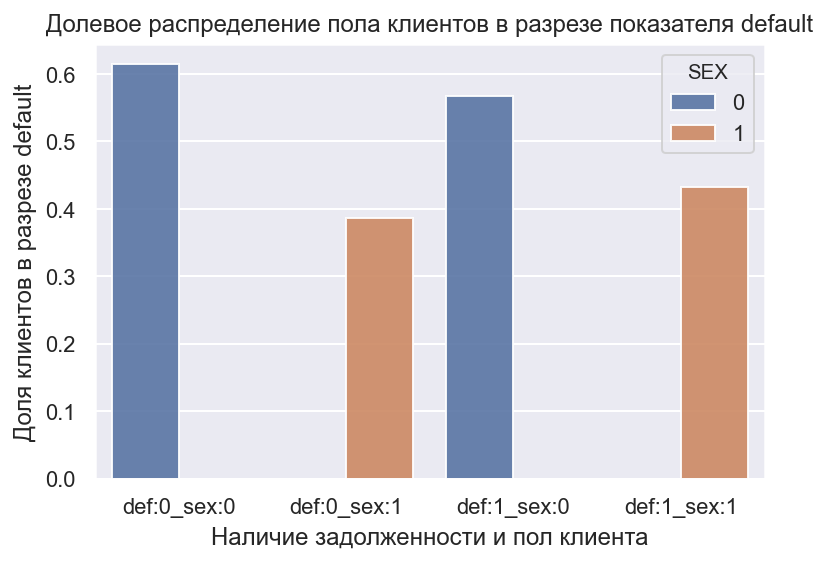

In [25]:
fig=plt.figure(figsize=(6,4))
sns.barplot(x="default_&_SEX", y="id_fraction", hue='SEX', data=df_grouped, alpha=0.9)
plt.xlabel('Наличие задолженности и пол клиента')
plt.ylabel('Доля клиентов в разрезе default')
plt.title('Долевое распределение пола клиентов в разрезе показателя default')
plt.show()

__1)__ Поскольку есть возможность исследовать гендерный состав с помощью долей, то можно использовать Z-критерий для доли. Используя Z-критерий для доли, рассмотрим  гипотезы о внутригрупповом (т.е. в рамках групп default=0 и default=1) распределении полов:


1. H0: p(мужчины, дефолт=0) = 0.5

   H1: p(мужчины, дефолт=0) != 0.5
   
   
2. H0: p(женщины, дефолт=0) = 0.5

   H1: p(женщины, дефолт=0) != 0.5
   
   
3. H0: p(мужчины, дефолт=1) = 0.5

   H1: p(мужчины, дефолт=1) != 0.5
   
   
4. H0: p(женщины, дефолт=1) = 0.5

   H1: p(женщины, дефолт=1) != 0.5


In [26]:
from statsmodels.stats.proportion import proportion_confint

In [27]:
p_hat = df_grouped[df_grouped['default_&_SEX']=='def:0_sex:1']['id_fraction'].values[0]
z_stat = st.norm.ppf(q=1 - alpha/2)
p0 = 0.5
n = df_grouped[df_grouped['default_&_SEX']=='def:0_sex:1']['id_sum'].values[0]

In [28]:
interval = [p_hat - z_stat*np.sqrt(( p_hat*(1-p_hat)/n )), 
            p_hat + z_stat*np.sqrt(( p_hat*(1-p_hat)/n ))]
interval

[0.37960806572767264, 0.3920919856333957]

In [29]:
# Проверка с помощью scipy
proportion_confint(count=p_hat*n, nobs=n, method = 'normal')

(0.37960806572767264, 0.3920919856333957)

In [30]:
# Статистика и достигаемый уровень значимости для двустороннего доверительного интервала
stat = (p_hat - p0)/ (np.sqrt(( p0*(1-p0)/n )))
p_value = 2*(1-st.norm.cdf(np.abs(stat)))

print('stat: ', stat, 'p_value: ', p_value)

stat:  -34.8963024694603 p_value:  0.0


Соответственно: 

H0: p(мужчины, дефолт=0) = 0.5 - отвергается с заданным уровнем значимости alpha = 0.05 

H1: p(мужчины, дефолт=0) != 0.5 - не отвергается с заданным уровнем значимости alpha = 0.05 

Получается, что среди не имеющих дефолт доля мужчин статистически меньше 50% от всех людей, не имеющих его. Т.е. структурно среди неимеющих дефолт людей мужчин меньше.

In [31]:
p_hat = df_grouped[df_grouped['default_&_SEX']=='def:0_sex:0']['id_fraction'].values[0]
z_stat = st.norm.ppf(q=1 - alpha/2)
p0 = 0.5
n = df_grouped[df_grouped['default_&_SEX']=='def:0_sex:0']['id_sum'].values[0]

In [32]:
interval = [p_hat - z_stat*np.sqrt(( p_hat*(1-p_hat)/n )), 
            p_hat + z_stat*np.sqrt(( p_hat*(1-p_hat)/n ))]
interval

[0.6079080143666044, 0.6203919342723273]

In [33]:
# Проверка с помощью scipy
proportion_confint(count=p_hat*n, nobs=n, method = 'normal')

(0.6079080143666044, 0.6203919342723273)

In [34]:
# Статистика и достигаемый уровень значимости для двустороннего доверительного интервала
stat = (p_hat - p0)/ (np.sqrt(( p0*(1-p0)/n )))
p_value = 2*(1-st.norm.cdf(np.abs(stat)))

print('stat: ', stat, 'p_value: ', p_value)

stat:  34.8963024694603 p_value:  0.0


Соответственно: 

H0: p(женщины, дефолт=0) = 0.5 - отвергается с заданным уровнем значимости alpha = 0.05 

H1: p(женщины, дефолт=0) != 0.5 - не отвергается с заданным уровнем значимости alpha = 0.05 

Зеркальная ситуация, дополняющая предыдущие выводы. Получается, что среди не имеющих дефолт доля женщин статистически больше 50% от всех людей, не имеющих его. Т.е. структурно среди неимеющих дефолт людей женщин больше.

---

In [35]:
p_hat = df_grouped[df_grouped['default_&_SEX']=='def:1_sex:1']['id_fraction'].values[0]
z_stat = st.norm.ppf(q=1 - alpha/2)
p0 = 0.5
n = df_grouped[df_grouped['default_&_SEX']=='def:1_sex:1']['id_sum'].values[0]

In [36]:
interval = [p_hat - z_stat*np.sqrt(( p_hat*(1-p_hat)/n )), 
            p_hat + z_stat*np.sqrt(( p_hat*(1-p_hat)/n ))]
interval

[0.4210202357094044, 0.44486282637618935]

In [37]:
# Проверка с помощью scipy
proportion_confint(count=p_hat*n, nobs=n, method = 'normal')

(0.4210202357094044, 0.44486282637618935)

In [38]:
# Статистика и достигаемый уровень значимости для двустороннего доверительного интервала
stat = (p_hat - p0)/ (np.sqrt(( p0*(1-p0)/n )))
p_value = 2*(1-st.norm.cdf(np.abs(stat)))

print('stat: ', stat, 'p_value: ', p_value)

stat:  -10.925386709120259 p_value:  0.0


Соответственно: 

H0: p(мужчины, дефолт=1) = 0.5 - отвергается с заданным уровнем значимости alpha = 0.05 

H1: p(мужчины, дефолт=1) != 0.5 - не отвергается с заданным уровнем значимости alpha = 0.05 

Получается, что среди имеющих дефолт доля мужчин статистически меньше 50% от всех людей, имеющих его. Т.е. структурно среди имеющих дефолт мужчин меньше.

---

In [39]:
p_hat = df_grouped[df_grouped['default_&_SEX']=='def:1_sex:0']['id_fraction'].values[0]
z_stat = st.norm.ppf(q=1 - alpha/2)
p0 = 0.5
n = df_grouped[df_grouped['default_&_SEX']=='def:1_sex:0']['id_sum'].values[0]

In [40]:
interval = [p_hat - z_stat*np.sqrt(( p_hat*(1-p_hat)/n )), 
            p_hat + z_stat*np.sqrt(( p_hat*(1-p_hat)/n ))]
interval

[0.5551371736238107, 0.5789797642905956]

In [41]:
# Проверка с помощью scipy
proportion_confint(count=p_hat*n, nobs=n, method = 'normal')

(0.5551371736238107, 0.5789797642905956)

In [42]:
# Статистика и достигаемый уровень значимости для двустороннего доверительного интервала
stat = (p_hat - p0)/ (np.sqrt(( p0*(1-p0)/n )))
p_value = 2*(1-st.norm.cdf(np.abs(stat)))

print('stat: ', stat, 'p_value: ', p_value)

stat:  10.925386709120259 p_value:  0.0


Соответственно: 

H0: p(женщины, дефолт=1) = 0.5 - отвергается с заданным уровнем значимости alpha = 0.05 

H1: p(женщины, дефолт=1) != 0.5 - не отвергается с заданным уровнем значимости alpha = 0.05 

Ситуация зеркально описывает предыдущий вывод.
Получается, что среди имеющих дефолт доля женщин статистически больше 50% от всех людей, имеющих его. Т.е. структурно среди имеющих дефолт женщин больше.

---

Указанные выводы статистически обосновывают преобладание женщин среди групп, вернувших денежные средства вовремя, и среди групп, не вернувших средства вовремя.

__2)__ 
Теперь попробуем ответить на вопрос, статистически ли значимо отличие доли мужчин и доли женщин между двумя группами: вернувших и не вернувших деньги вовремя. Для этого воспользумся статистическим тестом для доли в случае двух независимых выборок. Выборки независимые, поскольку измерения не проводятся на одних и тех же людях.

1. H0: p(мужчин| дефолт=1) =  p(мужчин| дефолт=0)
   H1: p(мужчин| дефолт=1) !=  p(мужчин| дефолт=0)
   
   
2. H0: p(женщин| дефолт=1) =  p(женщин| дефолт=0)
   H1: p(женщин| дефолт=1) !=  p(женщин| дефолт=0)

Мужчины:

In [43]:
p0 = df_grouped[df_grouped['default_&_SEX']=='def:0_sex:1']['id_fraction'].values[0]
p1 = df_grouped[df_grouped['default_&_SEX']=='def:1_sex:1']['id_fraction'].values[0]

n0 = df_grouped[df_grouped['default_&_SEX']=='def:0_sex:1']['id_sum'].values[0]
n1 = df_grouped[df_grouped['default_&_SEX']=='def:1_sex:1']['id_sum'].values[0]

In [44]:
z_stat = st.norm.ppf(q=1 - alpha/2)
stat = np.sqrt( (p0*(1-p0))/n0 + (p1*(1-p1))/n1)

In [45]:
interval = [p0-p1 - z_stat*stat, p0-p1 + z_stat*stat]
interval

[-0.060548077974896725, -0.03363493274962867]

In [46]:
p_ = (p0*n0 + p1*n1)/(n0 + n1)
stat = (p0 - p1)/ (  p_*(1 - p_)*(1/n0 + 1/n1) )

p_value = 2*(1-st.norm.cdf(np.abs(stat)))

print('stat: ', stat, 'p_value: ', p_value)

stat:  -1017.283961259149 p_value:  0.0


Соответственно, гипотеза о равенстве долей мужчин в группах с дефолтом и без отвергается. 
По доверительному интервалу разности долей можно видеть, что доля мужчин без дефолта меньше доли мужчин с дефолтом.

Женщины:

In [47]:
p0 = df_grouped[df_grouped['default_&_SEX']=='def:0_sex:0']['id_fraction'].values[0]
p1 = df_grouped[df_grouped['default_&_SEX']=='def:1_sex:0']['id_fraction'].values[0]

n0 = df_grouped[df_grouped['default_&_SEX']=='def:0_sex:0']['id_sum'].values[0]
n1 = df_grouped[df_grouped['default_&_SEX']=='def:1_sex:0']['id_sum'].values[0]

In [48]:
z_stat = st.norm.ppf(q=1 - alpha/2)
stat = np.sqrt( (p0*(1-p0))/n0 + (p1*(1-p1))/n1)

interval = [p0-p1 - z_stat*stat, p0-p1 + z_stat*stat]
interval

[0.03363493274962867, 0.060548077974896725]

In [49]:
p_ = (p0*n0 + p1*n1)/(n0 + n1)
stat = (p0 - p1)/ (  p_*(1 - p_)*(1/n0 + 1/n1) )

p_value = 2*(1-st.norm.cdf(np.abs(stat)))

print('stat: ', stat, 'p_value: ', p_value)

stat:  1017.283961259149 p_value:  0.0


Соответственно, гипотеза о равенстве долей женщин в группах с дефолтом и без отвергается. 
По доверительному интервалу разности долей можно видеть, что доля женщин без дефолта больше доли женщин с дефолтом.

---

__Задача 3.__

Образование (EDUCATION): Проверьте __гипотезу о том, что образование не влияет на то, вернет ли человек долг__. 

Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. 

Например, __составьте таблицу сопряженности "образование" на "возврат долга"__, где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек.

Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости ?

Наличие какого образования является наилучшим индикатором того, что человек отдаст долг ? наоборт, не отдаст долг ?

In [50]:
df_crosstab = pd.crosstab(df['EDUCATION'], df['default'])
df_crosstab

default,0,1
EDUCATION,,
0,14,0
1,8549,2036
2,10700,3330
3,3680,1237
4,116,7
5,262,18
6,43,8


In [51]:
contig_table = df_crosstab.values
contig_table

array([[   14,     0],
       [ 8549,  2036],
       [10700,  3330],
       [ 3680,  1237],
       [  116,     7],
       [  262,    18],
       [   43,     8]], dtype=int64)

Для того, чтобы проверить гипотезу, влияет ли образование на возврат долга, можно воспользоваться критерием Хи-квадрат Пирсона (критерий согласия), поскольку имеется два качественных признака, по которым возможно составить таблицу сопряженности и протестировать, отличаются ли эмпирические частоты сопряженной таблицы от теоретических.



H0: Ожидаемые частоты = теоретическим частотам. Т.е. нельзя отвергать факт того, что образование не влияет на невозврат кредита.

H1: Ожидаемые частоты != теоретическим частотам. Т.е. нулевая гипотеза об отсутствии зависимости между образованием и невозвратом кредита отличается.

In [52]:
from scipy.stats import chi2_contingency

In [53]:
chi2, p_value, dof, expected = chi2_contingency(contig_table)

In [54]:
print(f'\nchi^2: {chi2}\np-value: {p_value}\ndof: {dof}\nexpected:\n{expected}')


chi^2: 163.21655786997073
p-value: 1.2332626245415605e-32
dof: 6
expected:
[[1.0903200e+01 3.0968000e+00]
 [8.2435980e+03 2.3414020e+03]
 [1.0926564e+04 3.1034360e+03]
 [3.8293596e+03 1.0876404e+03]
 [9.5792400e+01 2.7207600e+01]
 [2.1806400e+02 6.1936000e+01]
 [3.9718800e+01 1.1281200e+01]]


---

Протестируем схожую гипотезу в ручном режиме, исходя из того, что теоретически дял каждой образовательной группы разбиение на людей с дефолтом и без осуществляется случайно (т.е. с p=0.5 происодит генерация значений 0 и 1) по биномиальному закону.

In [55]:
from collections import Counter

In [56]:
# Доля дефолтов в каждой группе образования
freq_list = (contig_table[:, 1]/contig_table.sum(axis=1)).tolist()
freq_list

[0.0,
 0.19234766178554558,
 0.23734853884533144,
 0.2515761643278422,
 0.056910569105691054,
 0.06428571428571428,
 0.1568627450980392]

In [57]:
# Смоделируем теоретические частоты для каждой группы в условиях
# равновероятностного исхода для отсутствия и наличия дефолта
# Также зафиксируем константу псевдослучайного генератора чисел для воспроизводимости

bernoulli_freq_list = []
seed = 42
binom_distr = st.bernoulli(p=0.5)
np.random.seed(seed)

for n in contig_table.sum(axis=1).tolist():
    _counter = Counter(binom_distr.rvs(size=n, random_state=seed).tolist())
    bernoulli_freq_list.append([_counter[0], _counter[1]])

bernoulli_freq_list = np.array(bernoulli_freq_list)
bernoulli_freq_list

array([[   6,    8],
       [5362, 5223],
       [7105, 6925],
       [2462, 2455],
       [  63,   60],
       [ 132,  148],
       [  28,   23]])

In [58]:
contig_table

array([[   14,     0],
       [ 8549,  2036],
       [10700,  3330],
       [ 3680,  1237],
       [  116,     7],
       [  262,    18],
       [   43,     8]], dtype=int64)

В том случае, если число ожидаемого явления меньше 10 хотя бы в одной ячейке, при анализе четырехпольных таблиц должен рассчитываться критерий хи-квадрат с поправкой Йейтса. Данная поправка позволяет уменьшить вероятность ошибки первого типа, т.е обнаружения различий там, где их нет. Поправка Йейтса заключается в вычитании 0,5 из абсолютного значения разности между фактическим и ожидаемым количеством наблюдений в каждой ячейке, что ведет к уменьшению величины критерия хи-квадрат.

* https://infopedia.su/9x6804.html

In [59]:
# Chi^2 test, degrees of freedom: (Rows-1)x(Columns-1)
doff = (bernoulli_freq_list.shape[0] - 1)*(bernoulli_freq_list.shape[1] - 1)
doff

6

In [60]:
chi2_stat = 0
chi2_stat_corrected = 0
yates_correction = 0.5

for row in range(bernoulli_freq_list.shape[0]):
    for column in range(bernoulli_freq_list.shape[1]):
        
        chi2_stat += ((contig_table[row, column] - 
                       bernoulli_freq_list[row, column])**2 ) / bernoulli_freq_list[row, column]
        
        chi2_stat_corrected += ((np.abs(contig_table[row, column] - 
                             bernoulli_freq_list[row, column]) 
                     - yates_correction)**2  ) / bernoulli_freq_list[row, column]

In [61]:
chi2_stat

9101.165249540518

In [62]:
chi2_stat_corrected

9090.940481123203

In [63]:
p_value = 1-st.chi2.cdf(chi2_stat, doff)
p_value

0.0

In [64]:
p_value = 1-st.chi2.cdf(chi2_stat_corrected, doff)
p_value

0.0

Соответственно, гипотеза о равенстве ожидаемых частот теоретическим (рапсределение Бернулли с p=0.5) отвергается с заданным уровнем значимости alpha. Нельзя отвергать, что степень образования определеяет вероятность возврата или невозврата кредита.


Для наглядности возьмем абсолтную разность наблюдаемых частот и теретических частот на основе биномиального распределения, отсортируем по возрастанию значения для поиска группы с наиболее отклоняющимися данным:

In [65]:
pd.DataFrame(np.abs(contig_table-bernoulli_freq_list)).sort_values(by=[0])

,0,1
0,8,8
6,15,15
4,53,53
5,130,130
3,1218,1218
1,3187,3187
2,3595,3595


Чтобы ответить на вопрос, наличие какого образования - индикатор того, что человек отдаст долг и
наоборот статистически попробуем обосновать с помощью доверительного интервала для доли. Это возможно благодаря тому, что данные порождены биномиальным распределением (значения 0 и 1). 

Соответственно, можно подсчитать долю дефолтов на наблюдаемых данных по каждой образовательной группе и оценить двухсторонний доверительынй интервал для доли.

Группа с наименьшим значением по правому концу интервала будет признана как группа с образованием - индикатором возврата долга с наибоьшей степенью вероятности,
а группа с наибольшим значением на парвом конце доверительного интервала - индикатор образовательной группы с наименьшей степенью вероятности.
Однако важно, что при пересечении доверительных интервалов необходимо дополнительно проводить првоерку на равенство долей в двух независимых группах.

С точки зрения репрезентацтивности группа без дефолтов (0-доктора) в таком случае не может быть проанализирована вовсе, ее мы отбросим.

In [66]:
from statsmodels.stats.proportion import proportion_confint
from statsmodels.sandbox.stats.multicomp import multipletests 

In [67]:
df_crosstab2 = df_crosstab[df_crosstab[1]!=0].copy(deep=True)

In [68]:
df_crosstab2

default,0,1
EDUCATION,,
1,8549,2036
2,10700,3330
3,3680,1237
4,116,7
5,262,18
6,43,8


In [69]:
array_test = df_crosstab2.values
array_test

array([[ 8549,  2036],
       [10700,  3330],
       [ 3680,  1237],
       [  116,     7],
       [  262,    18],
       [   43,     8]], dtype=int64)

In [70]:
n_list = array_test.sum(axis=1).tolist()
proportion_list = array_test[:, 1]/array_test.sum(axis=1)

In [71]:
for i, np_tuple in enumerate(zip(n_list, proportion_list)):
    i+=1
    n, p = np_tuple
    normal_interval = proportion_confint(n*p, n, method = 'normal')
    print(f'Education group {i}:. Conf. interval: {normal_interval}')

Education group 1:. Conf. interval: (0.18483907261273544, 0.1998562509583557)
Education group 2:. Conf. interval: (0.23030849133419215, 0.24438858635647073)
Education group 3:. Conf. interval: (0.2394476798217757, 0.26370464883390865)
Education group 4:. Conf. interval: (0.015968627127634798, 0.09785251108374732)
Education group 5:. Conf. interval: (0.03555820708240264, 0.09301322148902591)
Education group 6:. Conf. interval: (0.05705320644646174, 0.2566722837496167)


Имеется пересечение интервалов долей с группами образования: 2, 3, 6. Необходимо протестировать, различаются ли доли в группах 3 и 2, 3 и 6. Сравнение ведется относительно группы 3, поскольку она имеет самую большую вероятность дефолта по правому краю доверительного интервала.

Поскольку имеется множественное сравнение, небходимо добавить поправку. Используем поправку методом Холма с целью достижения большей мощности поправки. Выборки независимые, поскольку измерения проводятся на разных людях.

С другой стороны, имеется пересечение интервалов по 4 и 5 группам. Необходимо проверить, отличается ли доля в 4 группе относительно 5, поскольку в группе 5 наименьшая вероятность

Формально будет производиться попарное сравнение долей со следующей постановкой:

H0: p1 = p2

H1: p1 != p2

In [72]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [73]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [74]:
# Получим список из нулей и единиц по группе
def get_onez_zeros(array, group):
    # Переведем номер группы в индекс
    group_index = group-1
    subarray = array_test[group_index,:]
    zeros_list = [0 for i in range(subarray[0])]
    ones_list = [1 for i in range(subarray[1])]
    return zeros_list+ones_list

In [75]:
array_test

array([[ 8549,  2036],
       [10700,  3330],
       [ 3680,  1237],
       [  116,     7],
       [  262,    18],
       [   43,     8]], dtype=int64)

In [76]:
p_values = []
for group in [2, 6]:
    p_value = proportions_diff_z_test(proportions_diff_z_stat_ind(get_onez_zeros(array_test, 3),
                                                                  get_onez_zeros(array_test, group)))
    p_values.append(p_value)

In [77]:
p_values

[0.04473034193821812, 0.12047879675838336]

In [78]:
reject, p_corrected, a1, a2 = multipletests(p_values, 
                                            alpha = alpha, 
                                            method = 'holm') 

In [79]:
p_corrected

array([0.08946068, 0.1204788 ])

In [80]:
print("p-value: %f" % proportions_diff_z_test(proportions_diff_z_stat_ind(get_onez_zeros(array_test, 4),
                                                                          get_onez_zeros(array_test, 5))))

p-value: 0.777450


Итого, на основе проведенных тестов можно сказать, что нельзя отвергать следующие суждения:

1. Процент дефолта среди людей из образовательных групп 2, 6 и 3 одинаков.
2. Процент дефолта среди людей образовательных групп 4 и 5 одинаков.

Соответственно, можно сказать, что вероятность дефолта в сумме больше у людей, находящихся в группах с образованием категорий 2, 3, 6 (бакалавр, выпускник школы, нет данных).

Наименьший прцоент дефолта среди групп образования 4, 5 (начальное образование, прочее)

Статистически нельзя ничего сказать об образовательной группе 0 (доктора), поскольку выборка в рамках данной категории не репрезентативна.


---

__Задача 4.__

Семейное положение (MARRIAGE): Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.


Для начала необходимо очистить данные от лиц, семейный статус по которым неизвестен.

In [81]:
df['MARRIAGE'].unique()

array([1, 2, 3, 0], dtype=int64)

In [82]:
df2 = df[df['MARRIAGE'].isin([1,2])].copy(deep=True)

In [83]:
# 1- женат/замужем, 0- холост

In [84]:
df2['MARRIAGE'] = df2['MARRIAGE'].map({1:1, 2:0})

In [85]:
df_crosstab = pd.crosstab(df2['MARRIAGE'], df2['default'])
df_crosstab

default,0,1
MARRIAGE,,
0,12623,3341
1,10453,3206


В такой конфигурации данных - бинарных величин возможно использовать коэффициент корреляции Мэтьюса MCC для оценки силы связи между бинарными переменными.

In [86]:
array_marriage = df_crosstab.values
array_marriage

array([[12623,  3341],
       [10453,  3206]], dtype=int64)

In [87]:
def mcc_coef(array):
    assert array.size==4
    
    a = array[0, 0]
    d = array[1, 1]
    b = array[0, 1]
    c = array[1, 0]
    
    mcc = (a*d - b*c)/(np.sqrt( (a+b)*(a+c)*(b+d)*(c+d)  ))
    return mcc

In [88]:
mcc_coef(array_marriage)

0.030555369920445503

Степень взаимосвязи данных бинарных величин крайне мала. Проверим значимость данного показателя.

H0: MCC=0

H1: MCC!=0

Если нулевая гипотеза справедлива и значение коэффициента корреляции действительно равно 0, то статистика этого критерия имеет распределение хи-квадрат с одной степенью свободы.

Предварительно сверим предпосылки корректности применения Хи-квадрат в данном случае: объем выборки больше 40 наблюдений, а также соблюдается ряд следующих соотношений.

In [89]:
def check_requirements(array):
    assert array.size==4
    
    n = array.sum()
    a = array[0, 0]
    d = array[1, 1]
    b = array[0, 1]
    c = array[1, 0]
    
    assert n > 40
    assert (a+c)*(a+b)/n > 5
    assert (a+c)*(c+d)/n > 5
    assert (b+d)*(a+d)/n > 5
    assert (b+d)*(c+d)/n > 5
    
    print(f'OK:\n n: {n}')
    print(f'(a+c)*(a+b)/n: {(a+c)*(a+b)/n}\n(a+c)*(c+d)/n: {(a+c)*(c+d)/n}' +
          f'\n(b+d)*(a+d)/n: {(b+d)*(a+d)/n}\n(b+d)*(c+d)/n: {(b+d)*(c+d)/n}'
         )

In [90]:
check_requirements(array_marriage)

OK:
 n: 29623
(a+c)*(a+b)/n: 12435.7851669311
(a+c)*(c+d)/n: 10640.2148330689
(b+d)*(a+d)/n: 3498.3783884144077
(b+d)*(c+d)/n: 3018.785166931101


In [91]:
n = array_marriage.sum()
doff=1

chi2 = n*mcc_coef(array_marriage)
p_value = 1-st.chi2.cdf(chi2_stat_corrected, doff)

print(f'chi^2: {chi2}\np-value: {p_value}')

chi^2: 905.1417231533571
p-value: 0.0


Поскольку p-value < alpha=0.05, гипотеза H0 о равенстве коэффициента MCC нулю отвергается. Есть небольшая, слабая связь между вероятностью получения дефолта и семейным положение соответственно.

---

__Задача 5.__

Возраст (AGE): Относительно двух групп людей вернувших и не вернувших кредит проверьте следующие гипотезы: 

* a) о равенстве медианных значений возрастов людей
* b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

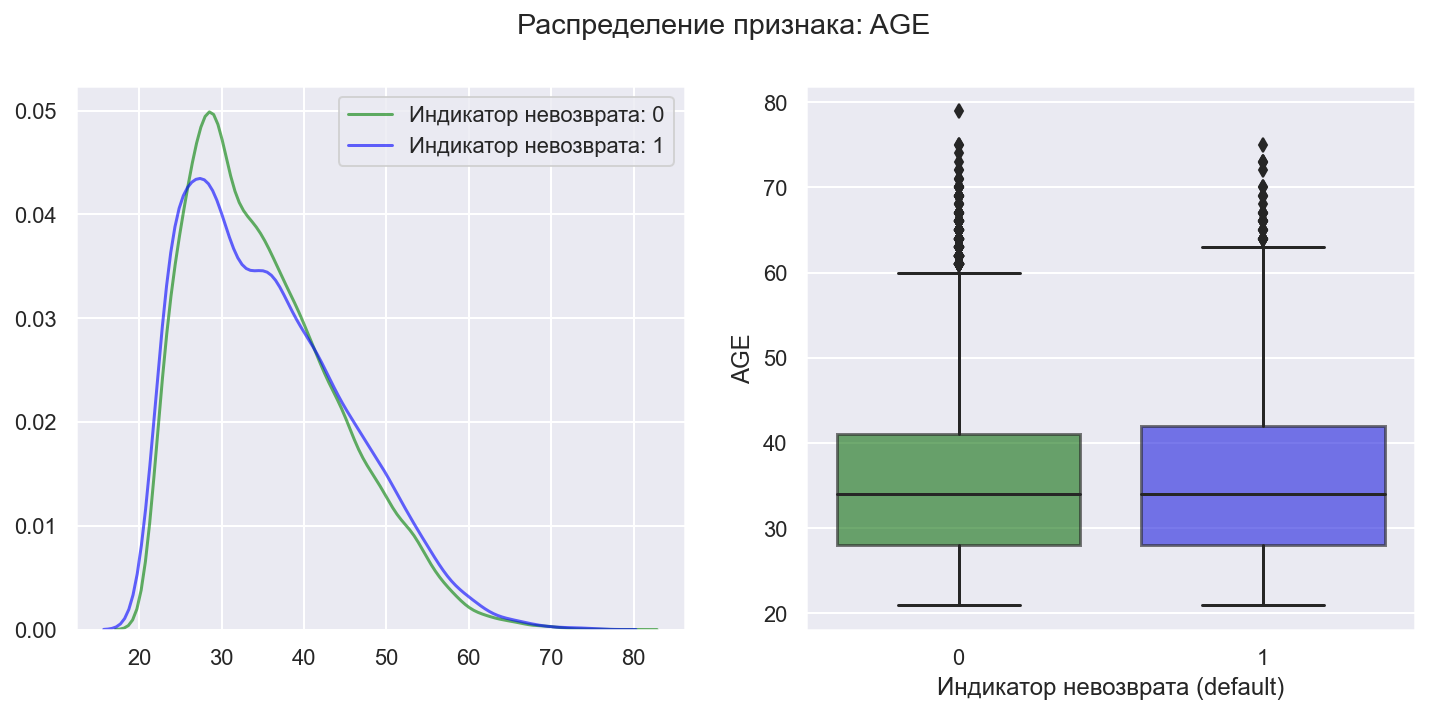

In [92]:
plot_grouped_feature(df, 'AGE', 'default', 'Индикатор невозврата')

Визуальный анализ распределений исходов дефолтов в зависимости от возраста не дал результатов. Медианы рапсределений одинаковы, разделить по порогу возраста распределения нельзя.

__a)__
Аналогично первой задаче, проведем интервальную оценку медианы с помощью бутстрепа. Для этого сгенерируем из выборки данных по группам default=1 и default=0 псевдовыборки с возвращением. Для каждой пары псевдовыборок расчитаем разницу их медиан и рассмотрим распределение разности медиан для сгенерированных псевдовыборок.

In [93]:
age_default_1 = df[df['default']==1]['AGE'].values
age_default_0 = df[df['default']==0]['AGE'].values

In [94]:
np.random.seed(0)

lb_def_1_median_scores = np.array(list(map(np.median, get_bootstrap_samples(age_default_1, 1000))))
lb_def_0_median_scores = np.array(list(map(np.median, get_bootstrap_samples(age_default_0, 1000))))

In [95]:
diff_value = lb_def_0_median_scores - lb_def_1_median_scores
stat_intervals(diff_value, alpha)

array([-1.,  0.])

Интервальная оценка разницы медиан с помощью бутстрепа показывает, что медианный возраст групп клиентов, вернувших кредит и не вернувших его, одинаков.

__b)__ Поскольку распределение признака `AGE` не является нормальным, нет возможности воспользоваться стандартными параметрическими тестами. Сравниваются значения по двум независимым выборкам, поэтому для проверки гипотезы о равенстве распределений с помощью рангового критерия равенства средних воспользуемся непараметрическим тестом Уилкоксона-Мана-Уитни. 

H0: $F_{Age|default=1}(x) = F_{Age|default=0}(x)$

H1: $F_{Age|default=1}(x) = F_{Age|default=0}(x+\Delta)$

$alpha = 0.05$

In [96]:
stats.mannwhitneyu(age_default_1, age_default_0)

MannwhitneyuResult(statistic=76966879.5, pvalue=0.1862517717449308)

p-value, т.е. достигаемый уровень значимости для проведенного теста ~0.186. (> alpha=0.05)

__Соответственно, гипотеза H0: $F_{Age|default=1}(x) = F_{Age|default=0}(x)$ не отвергается при заданном уровне alpha=0.05.__

Распределение возраста у лиц, имеющих задолженность, не отличается от распределения возраста без задолженностей с уровнем alpha=0.05.

Таким образом, исходя из полученный выборки, возраст в исследуемом банке не является информативным признаком относительно определения дефолта заемщика.

---